In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates 

# ========== CONFIGURARE ==========
SYMBOL = 'NQ=F'  # Simbol pentru Micro E-mini Nasdaq-100
TIMEFRAME = '1h'
END_DATE = datetime.today().strftime('%Y-%m-%d')
START_DATE = (datetime.today() - timedelta(days=59)).strftime('%Y-%m-%d')
EMA_PERIOD = 50
COMMISSION = 0.5  
INITIAL_BALANCE = 10000  # Sold inițial

# ========== PRELUARE DATE ==========
data = yf.download(SYMBOL, start=START_DATE, end=END_DATE, interval=TIMEFRAME)
# print(data.columns)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0].lower() for col in data.columns] 
else:
    data.columns = [col.lower() for col in data.columns]



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [2]:
# ========== CALCUL EMA ==========
data['ema50'] = data[('close')].ewm(span=EMA_PERIOD, adjust=False).mean()

/var/folders/ms/6dk8tbfd5js41998t28sbw_h0000gn/T/ipykernel_91424/4076097529.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_trades = pd.concat([df_trades, pd.DataFrame([{'Time': data.index[i], 'Type': 'BUY', 'Price': buy_price, 'StopLoss': stop_loss, 'TakeProfit': take_profit}])], ignore_index=True)


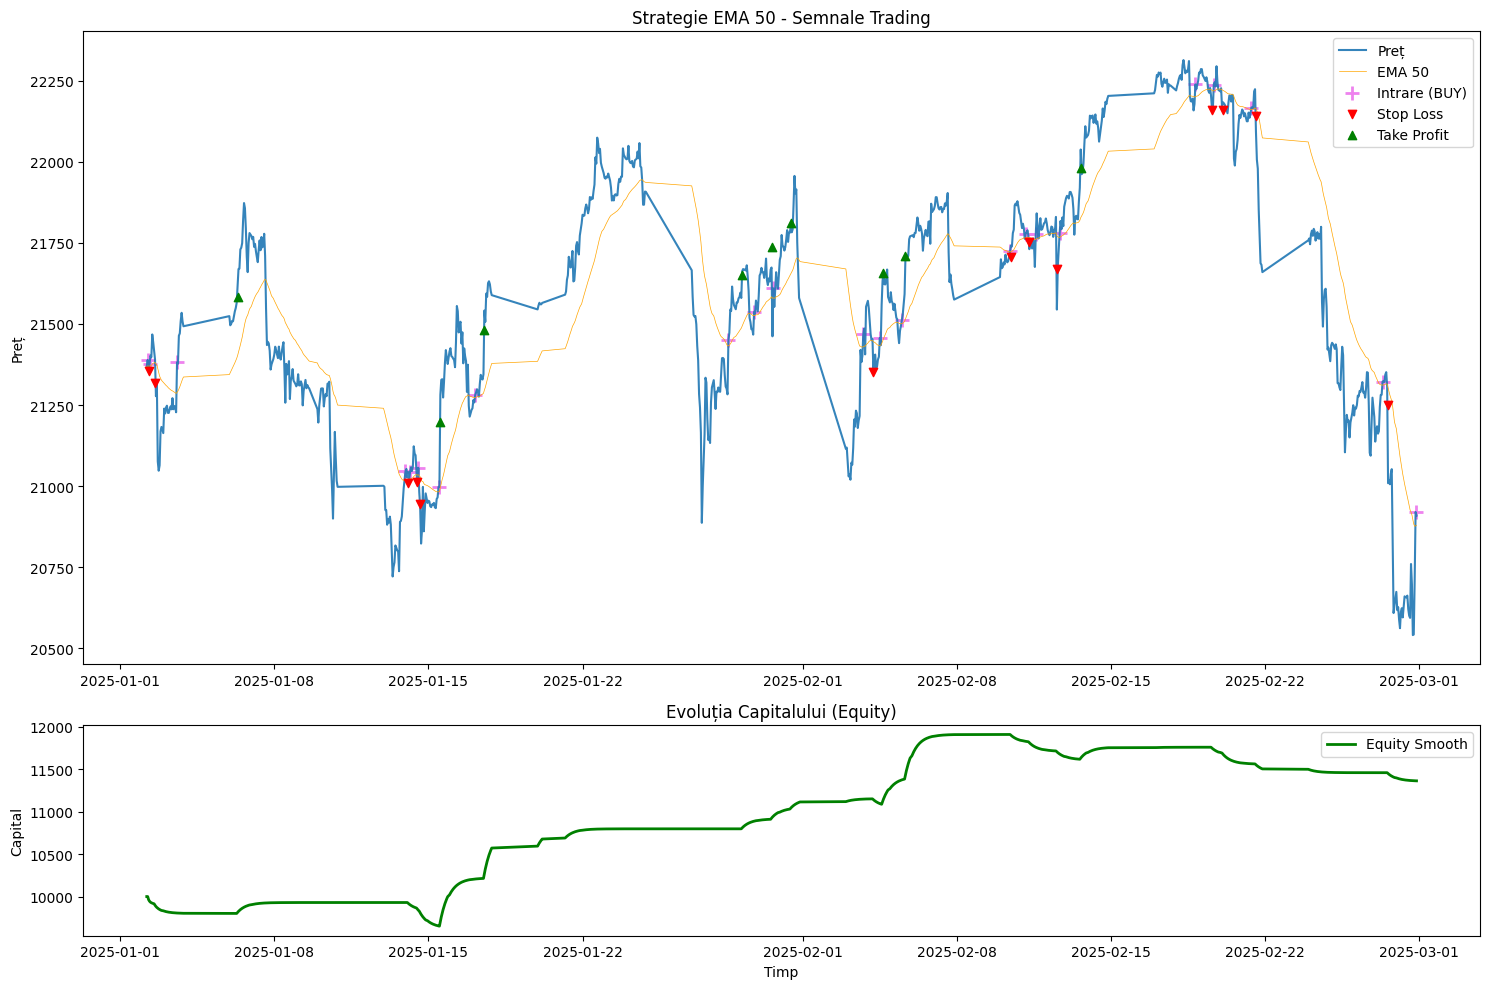

In [3]:
capital = 10000  
equity = [capital]  
position_open = False  
trades = []

# DataFrame pentru tranzacții
df_trades = pd.DataFrame(columns=['Time', 'Type', 'Price','StopLoss', 'TakeProfit'])

for i in range(1, len(data)):  #Cand pretul trece de EMA50, cumparam, risk management: stop loss si take profit fixate
    if not position_open: 
        if data['close'].iloc[i] > data['ema50'].iloc[i] and data['close'].iloc[i-1] <= data['ema50'].iloc[i-1]:
            buy_price = data['close'].iloc[i]
            stop_loss = data['low'].iloc[i]
            take_profit = buy_price + 200  
            trades.append(('BUY', data.index[i], buy_price, stop_loss, take_profit))
            df_trades = pd.concat([df_trades, pd.DataFrame([{'Time': data.index[i], 'Type': 'BUY', 'Price': buy_price, 'StopLoss': stop_loss, 'TakeProfit': take_profit}])], ignore_index=True)
            position_open = True  
    # Dacă avem o poziție activă, verificăm SL sau TP
    elif position_open:
        last_trade = trades[-1]
        buy_price, stop_loss, take_profit = last_trade[2], last_trade[3], last_trade[4]
        distance = buy_price - stop_loss  # Distanța dintre prețul de cumpărare(entry) și SL
        position_size = 100 / distance
        distance_tp = take_profit - buy_price  # Distanța dintre prețul de cumpărare(entry) și TP
        if data['low'].iloc[i] <= stop_loss:  # SL atins
            capital -= (distance) * position_size  
            position_open = False  
            df_trades = pd.concat([df_trades, pd.DataFrame([{'Time': data.index[i], 'Type': 'SELL', 'Price': stop_loss, 'StopLoss': stop_loss}])], ignore_index=True)
        
        elif data['high'].iloc[i] >= take_profit:  # TP atins
            capital += (distance_tp) * position_size
            position_open = False  
            df_trades = pd.concat([df_trades, pd.DataFrame([{'Time': data.index[i], 'Type': 'SELL', 'Price': take_profit, 'TakeProfit': take_profit}])], ignore_index=True)
    
    equity.append(capital)

# Grafic preț și semnale
fig, axes = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})  # 75% și 25%

# Subplot 1: Preț & EMA + Semnale BUY
axes[0].plot(data.index, data['close'], label='Preț', color='tab:blue', alpha=0.9) 
axes[0].plot(data.index, data['ema50'], label='EMA 50', color='orange', linewidth=0.5)  

# Plot entry points
axes[0].scatter(df_trades[df_trades['Type']=='BUY']['Time'], 
                df_trades[df_trades['Type']=='BUY']['Price'], 
                marker='+', color='violet',label='Intrare (BUY)',s=100, linewidths=2)

#Plot stop loss
axes[0].scatter(df_trades[df_trades['Type']=='SELL']['Time'], 
                df_trades[df_trades['Type']=='SELL']['StopLoss'], 
                marker='v', color='r', label='Stop Loss', zorder=3)

#Plot take profit
axes[0].scatter(df_trades[df_trades['Type']=='SELL']['Time'], 
                df_trades[df_trades['Type']=='SELL']['TakeProfit'], 
                marker='^', color='g', label='Take Profit', zorder=3)

axes[0].set_title('Strategie EMA 50 - Semnale Trading')
axes[0].legend()

# Subplot 2: Evoluție Capital 
equity_smooth = pd.Series(equity).ewm(alpha=0.1).mean()
axes[1].plot(data.index, equity_smooth, label='Equity Smooth', color='g', linewidth=2)
axes[1].set_title('Evoluția Capitalului (Equity)')
axes[1].legend()

axes[0].set_ylabel('Preț')
axes[1].set_ylabel('Capital')
axes[1].set_xlabel('Timp')

plt.tight_layout()
plt.show()